# Files & imports

In [66]:
from pandas import read_csv, DataFrame
import pandas as pd

In [67]:
#get file from data pre processing notebook. This file has all the column we need to start the data profiling phase
filepath = r'dataset/df_msg_pre_proc.csv'

file_tag = 'df_msg_pre_proc'

#data = pd.read_csv(filepath)

In [68]:
%run "dslabs_functions.py"

dslabs_functions loaded


# Load test data

In [69]:
test_data=True
#test_data=False

if test_data==True:

    data=pd.read_csv(filepath)

    # 5% sample
    data=data.sample(frac=0.10, replace=False)

    # sampled data to use in heavy analysis scripts like sparsity
    sampled_data=data.sample(frac=0.15, replace=False)


else:
    data=pd.read_csv(filepath)
    
    # sampled data to use in heavy analysis scripts like sparsity
    sampled_data=data.sample(frac=0.01, replace=False)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81532 entries, 134553 to 285288
Data columns (total 37 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   channel_msg                              81532 non-null  object 
 1   platform                                 5503 non-null   object 
 2   email_provider                           39245 non-null  object 
 3   sent_at                                  81532 non-null  object 
 4   is_opened                                81532 non-null  object 
 5   is_clicked                               81532 non-null  object 
 6   is_unsubscribed                          81532 non-null  object 
 7   is_hard_bounced                          81532 non-null  object 
 8   is_soft_bounced                          81532 non-null  object 
 9   is_complained                            81532 non-null  object 
 10  is_purchased                             8153

In [70]:
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12230 entries, 530455 to 39205
Data columns (total 37 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   channel_msg                              12230 non-null  object 
 1   platform                                 832 non-null    object 
 2   email_provider                           5886 non-null   object 
 3   sent_at                                  12230 non-null  object 
 4   is_opened                                12230 non-null  object 
 5   is_clicked                               12230 non-null  object 
 6   is_unsubscribed                          12230 non-null  object 
 7   is_hard_bounced                          12230 non-null  object 
 8   is_soft_bounced                          12230 non-null  object 
 9   is_complained                            12230 non-null  object 
 10  is_purchased                             12230

# Dimensionality

Understand the ratio between the number of records and variables

In [71]:
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_bar_chart

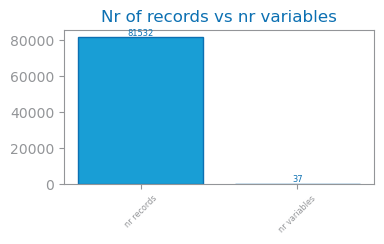

In [72]:
figure(figsize=(4, 2))
values: dict[str, int] = {"nr records": data.shape[0], "nr variables": data.shape[1]}
plot_bar_chart(
    list(values.keys()), list(values.values()), title="Nr of records vs nr variables"
)
savefig(f"./{file_tag}_records_variables.png") #save for later step
show()

## Missing values

Variables with their respective percentages of missing values:


days_diff_complained_at_sent_at: 99.96%
days_diff_purchased_at_sent_at: 99.92%
days_diff_clicked_first_time_at_sent_at: 98.29%
days_diff_unsubscribed_at_sent_at: 96.32%
platform: 93.25%
days_diff_opened_first_time_at_sent_at: 85.28%
days_diff_first_purchase_date_sent_at: 80.54%
email_provider: 51.87%
total_count: 13.43%
days_diff_started_at_sent_at: 13.43%
subject_length: 10.42%
subject_with_personalization: 10.42%
subject_with_deadline: 10.42%
subject_with_emoji: 10.42%
subject_with_bonuses: 10.42%
subject_with_discount: 10.42%
subject_with_saleout: 10.42%
topic: 0.86%


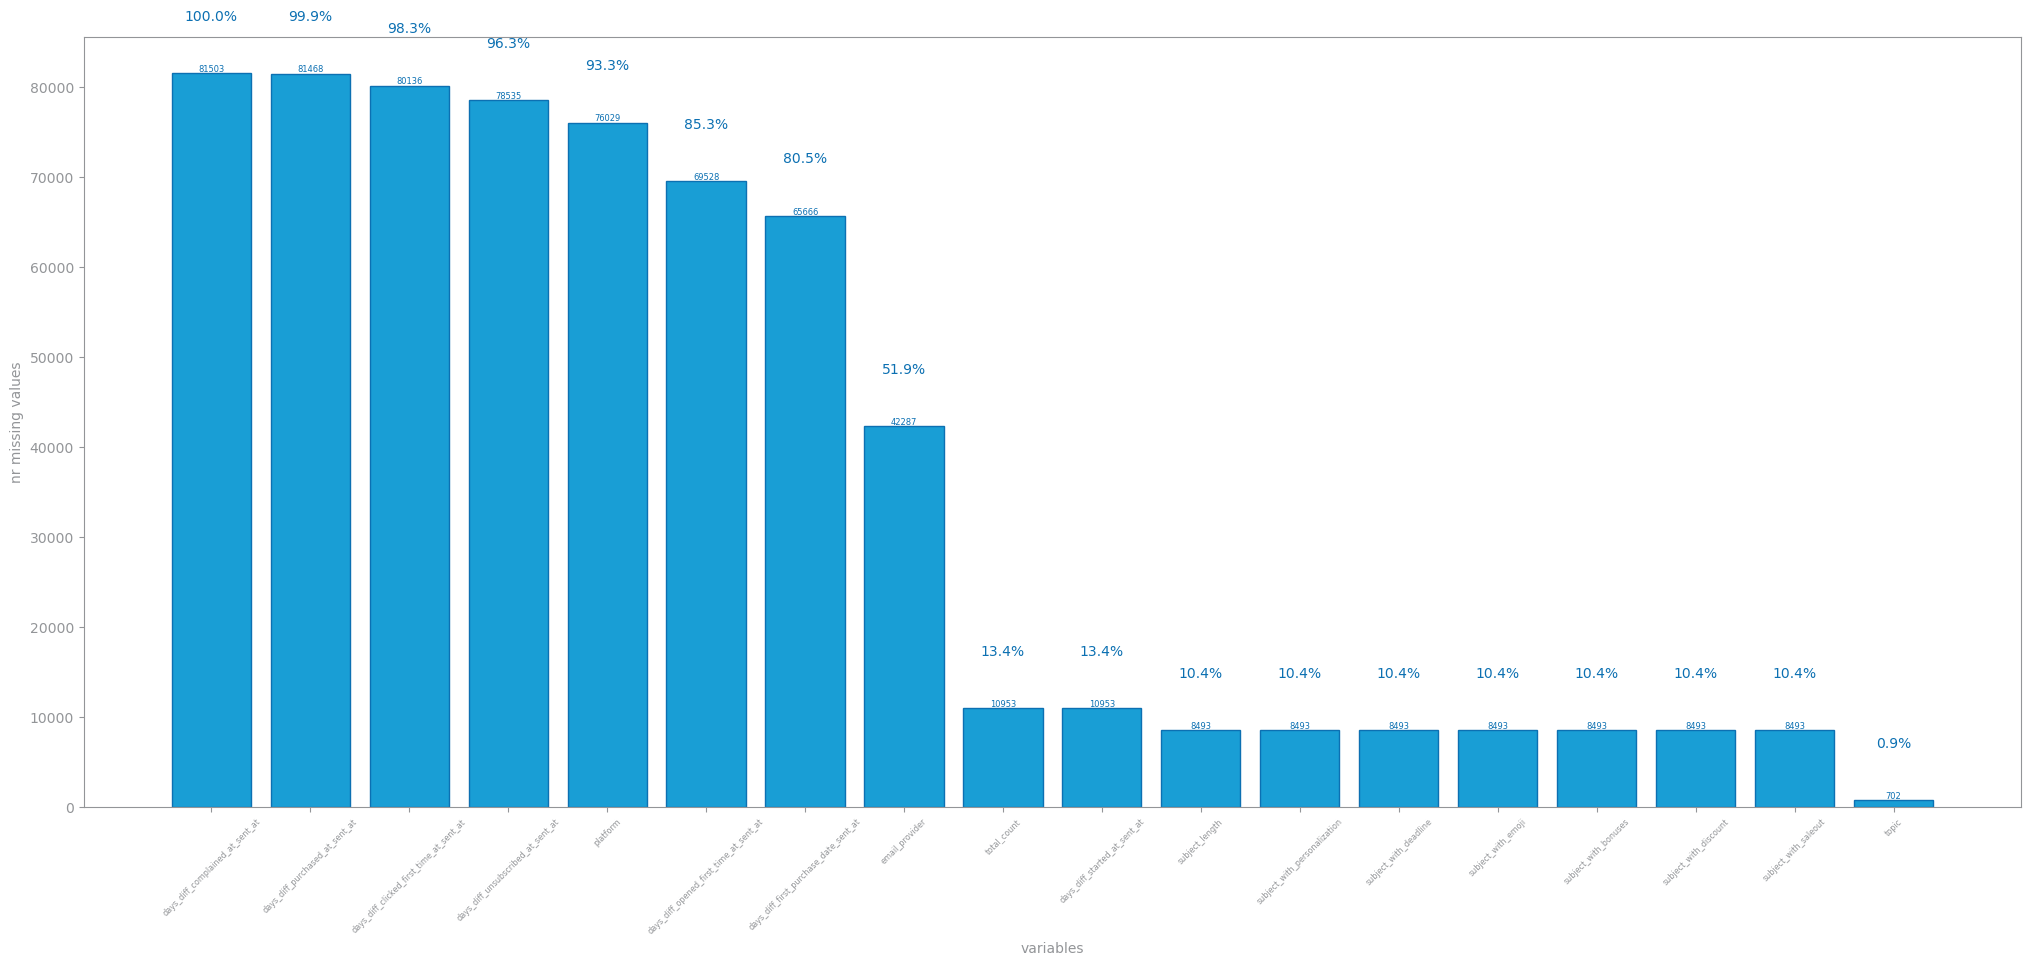

In [73]:
mv: dict[str, int] = {}
total_rows = len(data)

# Calculate the number of missing values and percentage for each variable
for var in data.columns:
    nr: int = data[var].isna().sum()
    if nr > 0:
        percentage = (nr / total_rows) * 100
        mv[var] = (nr, percentage)

# Sort the dictionary by the number of missing values in descending order
sorted_mv = dict(sorted(mv.items(), key=lambda item: item[1][0], reverse=True))

variables = list(sorted_mv.keys())
missing_values = [val[0] for val in sorted_mv.values()]
percentages = [val[1] for val in sorted_mv.values()]

# Print the list of variables with their respective percentages of missing values
print("Variables with their respective percentages of missing values:")
for var, perc in zip(variables, percentages):
    print(f"{var}: {perc:.2f}%")

# Plotting the bar chart
figure(figsize=(25, 10))  # (width, height)

plot_bar_chart(
    variables,
    missing_values,
    xlabel="variables",
    ylabel="nr missing values",
)

# Annotate the bars with percentages
for i, (var, perc) in enumerate(zip(variables, percentages)):
    text(i, missing_values[i] + max(missing_values) * 0.08, f"{perc:.1f}%", ha="center", va="center_baseline")

# Display the chart
show()


## Variables types

In [74]:
data.dtypes

channel_msg                                 object
platform                                    object
email_provider                              object
sent_at                                     object
is_opened                                   object
is_clicked                                  object
is_unsubscribed                             object
is_hard_bounced                             object
is_soft_bounced                             object
is_complained                               object
is_purchased                                object
campaign_type                               object
channel_cmp                                 object
topic                                       object
total_count                                float64
subject_length                             float64
subject_with_personalization                object
subject_with_deadline                       object
subject_with_emoji                          object
subject_with_bonuses           

In [75]:
from pandas import Series, to_numeric, to_datetime


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        else:
        # Check if the column is already of datetime type
            if pd.api.types.is_datetime64_any_dtype(df[c]):
                variable_types["date"].append(c)
            else:
                try:
                    to_numeric(df[c], errors="raise")
                    variable_types["numeric"].append(c)
                except ValueError:
                    try:
                        df[c] = to_datetime(df[c], errors="raise")
                        variable_types["date"].append(c)
                    except ValueError:
                        variable_types["symbolic"].append(c)

    return variable_types

{'numeric': ['total_count', 'subject_length', 'week_of_month', 'day_of_week_nr', 'day_of_month', 'hour', 'min', 'days_diff_opened_first_time_at_sent_at', 'days_diff_clicked_first_time_at_sent_at', 'days_diff_unsubscribed_at_sent_at', 'days_diff_complained_at_sent_at', 'days_diff_purchased_at_sent_at', 'days_diff_first_purchase_date_sent_at'], 'binary': ['channel_msg', 'is_opened', 'is_clicked', 'is_unsubscribed', 'is_hard_bounced', 'is_soft_bounced', 'is_complained', 'is_purchased', 'subject_with_personalization', 'subject_with_deadline', 'subject_with_emoji', 'subject_with_bonuses', 'subject_with_discount', 'subject_with_saleout', 'is_weekend', 'days_diff_started_at_sent_at'], 'date': ['sent_at'], 'symbolic': ['platform', 'email_provider', 'campaign_type', 'channel_cmp', 'topic', 'month', 'time_of_day']}


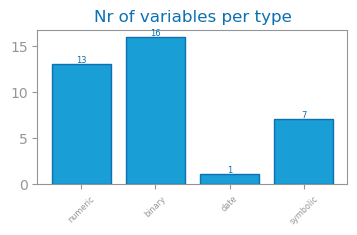

In [76]:
variable_types: dict[str, list] = get_variable_types(data)
print(variable_types)
counts: dict[str, int] = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])

figure(figsize=(4, 2))
plot_bar_chart(
    list(counts.keys()), list(counts.values()), title="Nr of variables per type"
)
savefig(f"./{file_tag}_variable_types.png")
show()

In [77]:
# Calculate the number of distinct values for each column
distinct_counts = {var_type: {col: data[col].nunique() for col in cols} for var_type, cols in variable_types.items()}

# Print the results
for var_type, counts in distinct_counts.items():
    print(f"{var_type.capitalize()} Variables:")
    for col, count in counts.items():
        print(f"  {col}: {count} distinct values")
    print()

Numeric Variables:
  total_count: 35 distinct values
  subject_length: 30 distinct values
  week_of_month: 5 distinct values
  day_of_week_nr: 7 distinct values
  day_of_month: 31 distinct values
  hour: 22 distinct values
  min: 60 distinct values
  days_diff_opened_first_time_at_sent_at: 73 distinct values
  days_diff_clicked_first_time_at_sent_at: 27 distinct values
  days_diff_unsubscribed_at_sent_at: 36 distinct values
  days_diff_complained_at_sent_at: 14 distinct values
  days_diff_purchased_at_sent_at: 8 distinct values
  days_diff_first_purchase_date_sent_at: 766 distinct values

Binary Variables:
  channel_msg: 2 distinct values
  is_opened: 2 distinct values
  is_clicked: 2 distinct values
  is_unsubscribed: 2 distinct values
  is_hard_bounced: 2 distinct values
  is_soft_bounced: 2 distinct values
  is_complained: 2 distinct values
  is_purchased: 2 distinct values
  subject_with_personalization: 2 distinct values
  subject_with_deadline: 2 distinct values
  subject_with_em

# Distribution

In [78]:
summary5: DataFrame = data.describe(include="all")
summary5

channel_msg platform email_provider                        sent_at  \
count         81532     5503          39245                          81532   
unique            2        4             61                            NaN   
top     mobile_push  desktop        mail.ru                            NaN   
freq          42287     4234          22407                            NaN   
mean            NaN      NaN            NaN  2021-05-18 08:23:47.349359616   
min             NaN      NaN            NaN            2021-04-30 05:06:31   
25%             NaN      NaN            NaN  2021-05-06 09:37:13.750000128   
50%             NaN      NaN            NaN            2021-05-20 08:22:58   
75%             NaN      NaN            NaN  2021-05-27 09:22:07.249999872   
max             NaN      NaN            NaN            2021-06-14 16:35:04   
std             NaN      NaN            NaN                            NaN   

       is_opened is_clicked is_unsubscribed is_hard_bounced is_soft_bounced  \
count      81532      81532           81532           81532           81532   
unique         2          2               2               2               2   
top            f          f               f               f               f   
freq       69528      80136           78535           81322           81494   
mean         NaN        NaN             NaN             NaN             NaN   
min          NaN        NaN             NaN             NaN             NaN   
25%          NaN        NaN             NaN             NaN             NaN   
50%          NaN        NaN             NaN             NaN             NaN   
75%          NaN        NaN             NaN             NaN             NaN   
max          NaN        NaN             NaN             NaN             NaN   
std          NaN        NaN             NaN             NaN             NaN   

       is_complained  ...          hour           min time_of_day  \
count          81532  ...  81532.000000  81532.000000       81532   
unique             2  ...           NaN           NaN           4   
top                f  ...           NaN           NaN     Morning   
freq           81503  ...           NaN           NaN       70688   
mean             NaN  ...      8.779338     27.184995         NaN   
min              NaN  ...      0.000000      0.000000         NaN   
25%              NaN  ...      7.000000     11.000000         NaN   
50%              NaN  ...      8.000000     27.000000         NaN   
75%              NaN  ...      9.000000     41.000000         NaN   
max              NaN  ...     23.000000     59.000000         NaN   
std              NaN  ...      2.433719     17.725017         NaN   

       days_diff_opened_first_time_at_sent_at  \
count                            12004.000000   
unique                                    NaN   
top                                       NaN   
freq                                      NaN   
mean                                 1.074392   
min                                  0.000000   
25%                                  0.000000   
50%                                  0.000000   
75%                                  0.000000   
max                                238.000000   
std                                  6.424684   

        days_diff_clicked_first_time_at_sent_at  \
count                               1396.000000   
unique                                      NaN   
top                                         NaN   
freq                                        NaN   
mean                                   0.845272   
min                                    0.000000   
25%                                    0.000000   
50%                                    0.000000   
75%                                    0.000000   
max                                   51.000000   
std                                    3.094981   

        days_diff_unsubscribed_at_sent_at days_diff_complained_at_sent_at  \
count         

Numerical variables indiv

In [79]:
#Use a variable from the dataset - Note: i dont have numeric variables in my dataset 
var: str = "subject_length"
print(f"Summary for {var} variable:")
print("\tCount: ", summary5[var]["count"])
print("\tMean: ", summary5[var]["mean"])
print("\tStDev: ", summary5[var]["std"])
print("\tMin: ", summary5[var]["min"])
print("\tQ1: ", summary5[var]["25%"])
print("\tMedian: ", summary5[var]["50%"])
print("\tQ3: ", summary5[var]["75%"])
print("\tMax: ", summary5[var]["max"])

Summary for subject_length variable:
	Count:  73039.0
	Mean:  108.09270389791754
	StDev:  23.255098400202343
	Min:  32.0
	Q1:  97.0
	Median:  97.0
	Q3:  127.0
	Max:  185.0


Non-numerical variables indiv

In [80]:
var = "email_provider"
print(f"Summary for {var} variable:")
print("\tCount: ", summary5[var]["count"])
print("\tUnique: ", summary5[var]["unique"])
print("\tTop: ", summary5[var]["top"])
print("\tFreq: ", summary5[var]["freq"])

Summary for email_provider variable:
	Count:  39245
	Unique:  61
	Top:  mail.ru
	Freq:  22407


## Numeric variables

In [81]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT


Fixing date type as numeric

In [82]:
#date_columns = ['date', 'sent_at', "opened_first_time_at", "opened_last_time_at", "clicked_first_time_at", "clicked_last_time_at",
#                "unsubscribed_at", "hard_bounced_at", "soft_bounced_at", "complained_at", "blocked_at", "purchased_at", "created_at",
#                  "updated_at", "first_purchase_date", "started_at", "finished_at"]
#
## Convert all listed columns to datetime
#for col in date_columns:
#    data[col] = pd.to_datetime(data[col], errors='coerce')


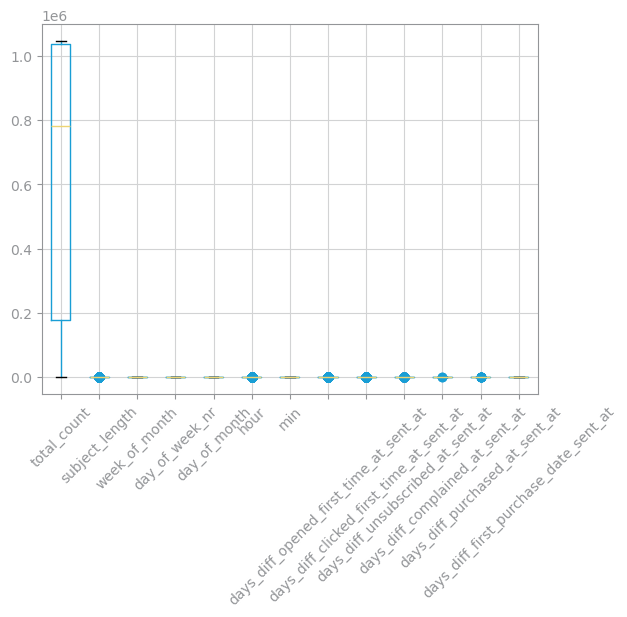

In [83]:
from matplotlib.pyplot import savefig, show
from dslabs_functions import get_variable_types

variables_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = variables_types["numeric"]
if [] != numeric:
    data[numeric].boxplot(rot=45)
    savefig(f"./{file_tag}_global_boxplot.png")
    show()
else:
    print("There are no numeric variables.")

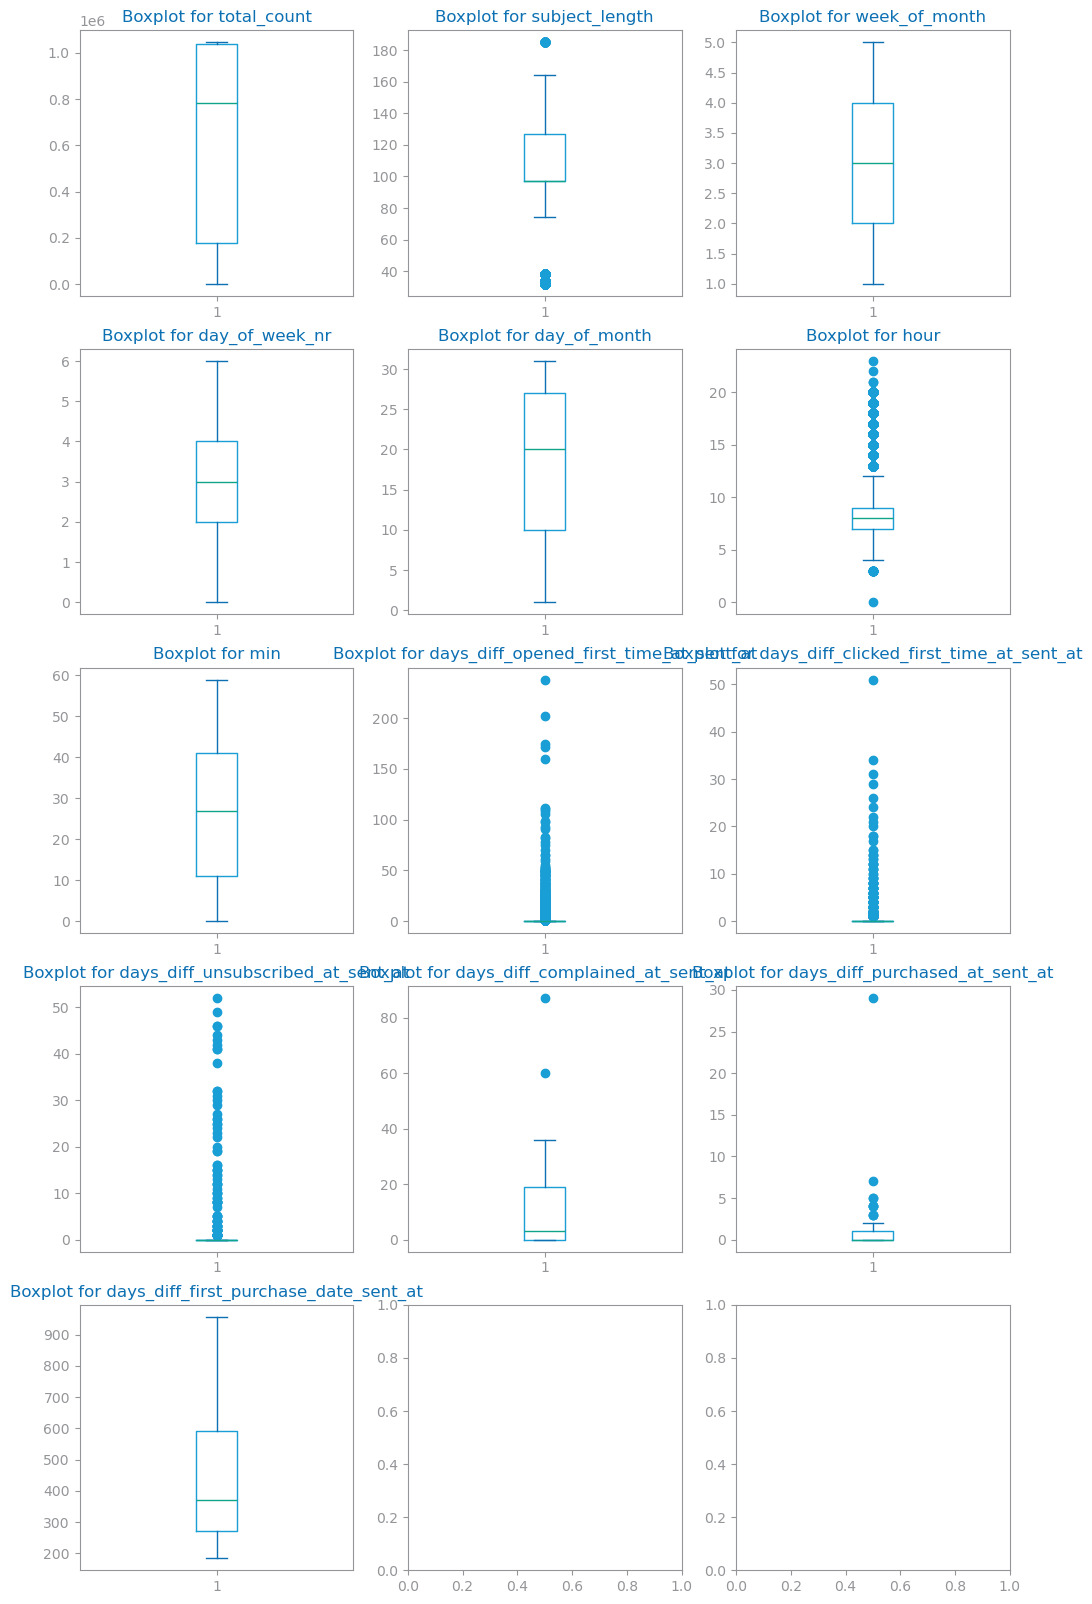

In [84]:

numeric: list[str] = variable_types["numeric"]

if [] != numeric:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric))
    fig: Figure
    axs: ndarray
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(numeric)):
        axs[i, j].set_title("Boxplot for %s" % numeric[n])
        axs[i, j].boxplot(data[numeric[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"./{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

## Outliers

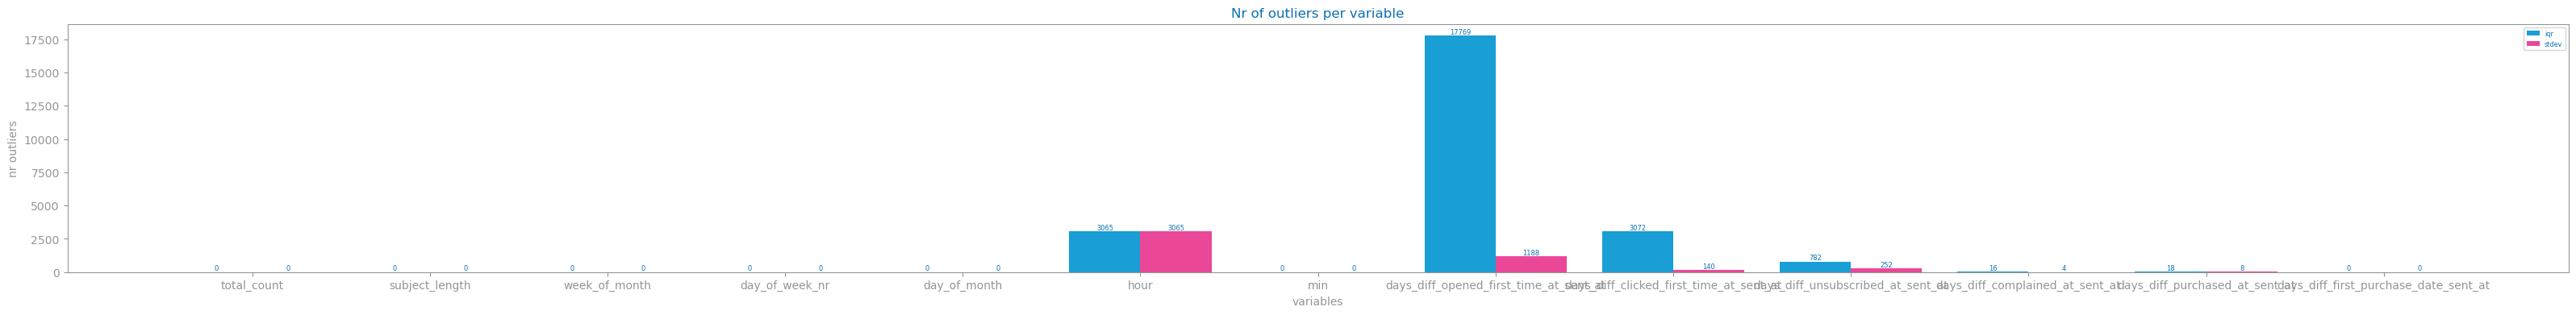

In [103]:
import numpy as np
from pandas import Series, DataFrame
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_multibar_chart

NR_STDEV: int = 2
IQR_FACTOR: float = 1.5


def determine_outlier_thresholds_for_var(
    summary5: Series, std_based: bool = True, threshold: float = NR_STDEV
) -> tuple[float, float]:
    top: float = 0
    bottom: float = 0
    
    if std_based:
        # Check for NaN or NaT before doing the calculation
        if pd.isna(summary5["mean"]) or pd.isna(summary5["std"]):
            return np.nan, np.nan
        std: float = threshold * summary5["std"]
        top = summary5["mean"] + std
        bottom = summary5["mean"] - std
    else:
        if pd.isna(summary5["75%"]) or pd.isna(summary5["25%"]):
            return np.nan, np.nan
        iqr: float = threshold * (summary5["75%"] - summary5["25%"])
        top = summary5["75%"] + iqr
        bottom = summary5["25%"] - iqr

    return top, bottom


def count_outliers(
    data: DataFrame,
    numeric: list[str],
    nrstdev: int = NR_STDEV,
    iqrfactor: float = IQR_FACTOR,
) -> dict:
    outliers_iqr: list = []
    outliers_stdev: list = []
    valid_numeric: list = []  # This will store only the variables with valid outlier counts
    summary5: DataFrame = data[numeric].describe()

    for var in numeric:
        top: float
        bottom: float
        
        # Check if we can compute std-based outliers
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=True, threshold=nrstdev
        )
        if not pd.isna(top) and not pd.isna(bottom):
            outliers_stdev_count = (
                data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
            )
            outliers_stdev.append(outliers_stdev_count)

            # Check if we can compute IQR-based outliers
            top, bottom = determine_outlier_thresholds_for_var(
                summary5[var], std_based=False, threshold=iqrfactor
            )
            if not pd.isna(top) and not pd.isna(bottom):
                outliers_iqr_count = (
                    data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
                )
                outliers_iqr.append(outliers_iqr_count)
                valid_numeric.append(var)  # Add to valid list if both checks pass

    return {"iqr": outliers_iqr, "stdev": outliers_stdev, "valid_numeric": valid_numeric}


if numeric:
    outliers: dict[str, int] = count_outliers(data, numeric, nrstdev=4, iqrfactor=4.5)
    
    # Use only the valid variables for which we have calculated outliers
    valid_numeric = outliers["valid_numeric"]
    
    figure(figsize=(40, HEIGHT))
    plot_multibar_chart(
        valid_numeric,  # Use only valid numeric columns
        {"iqr": outliers["iqr"], "stdev": outliers["stdev"]},  # Use valid outliers
        title="Nr of outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    savefig(f"./{file_tag}_outliers.png")
    show()
else:
    print("There are no numeric variables.")


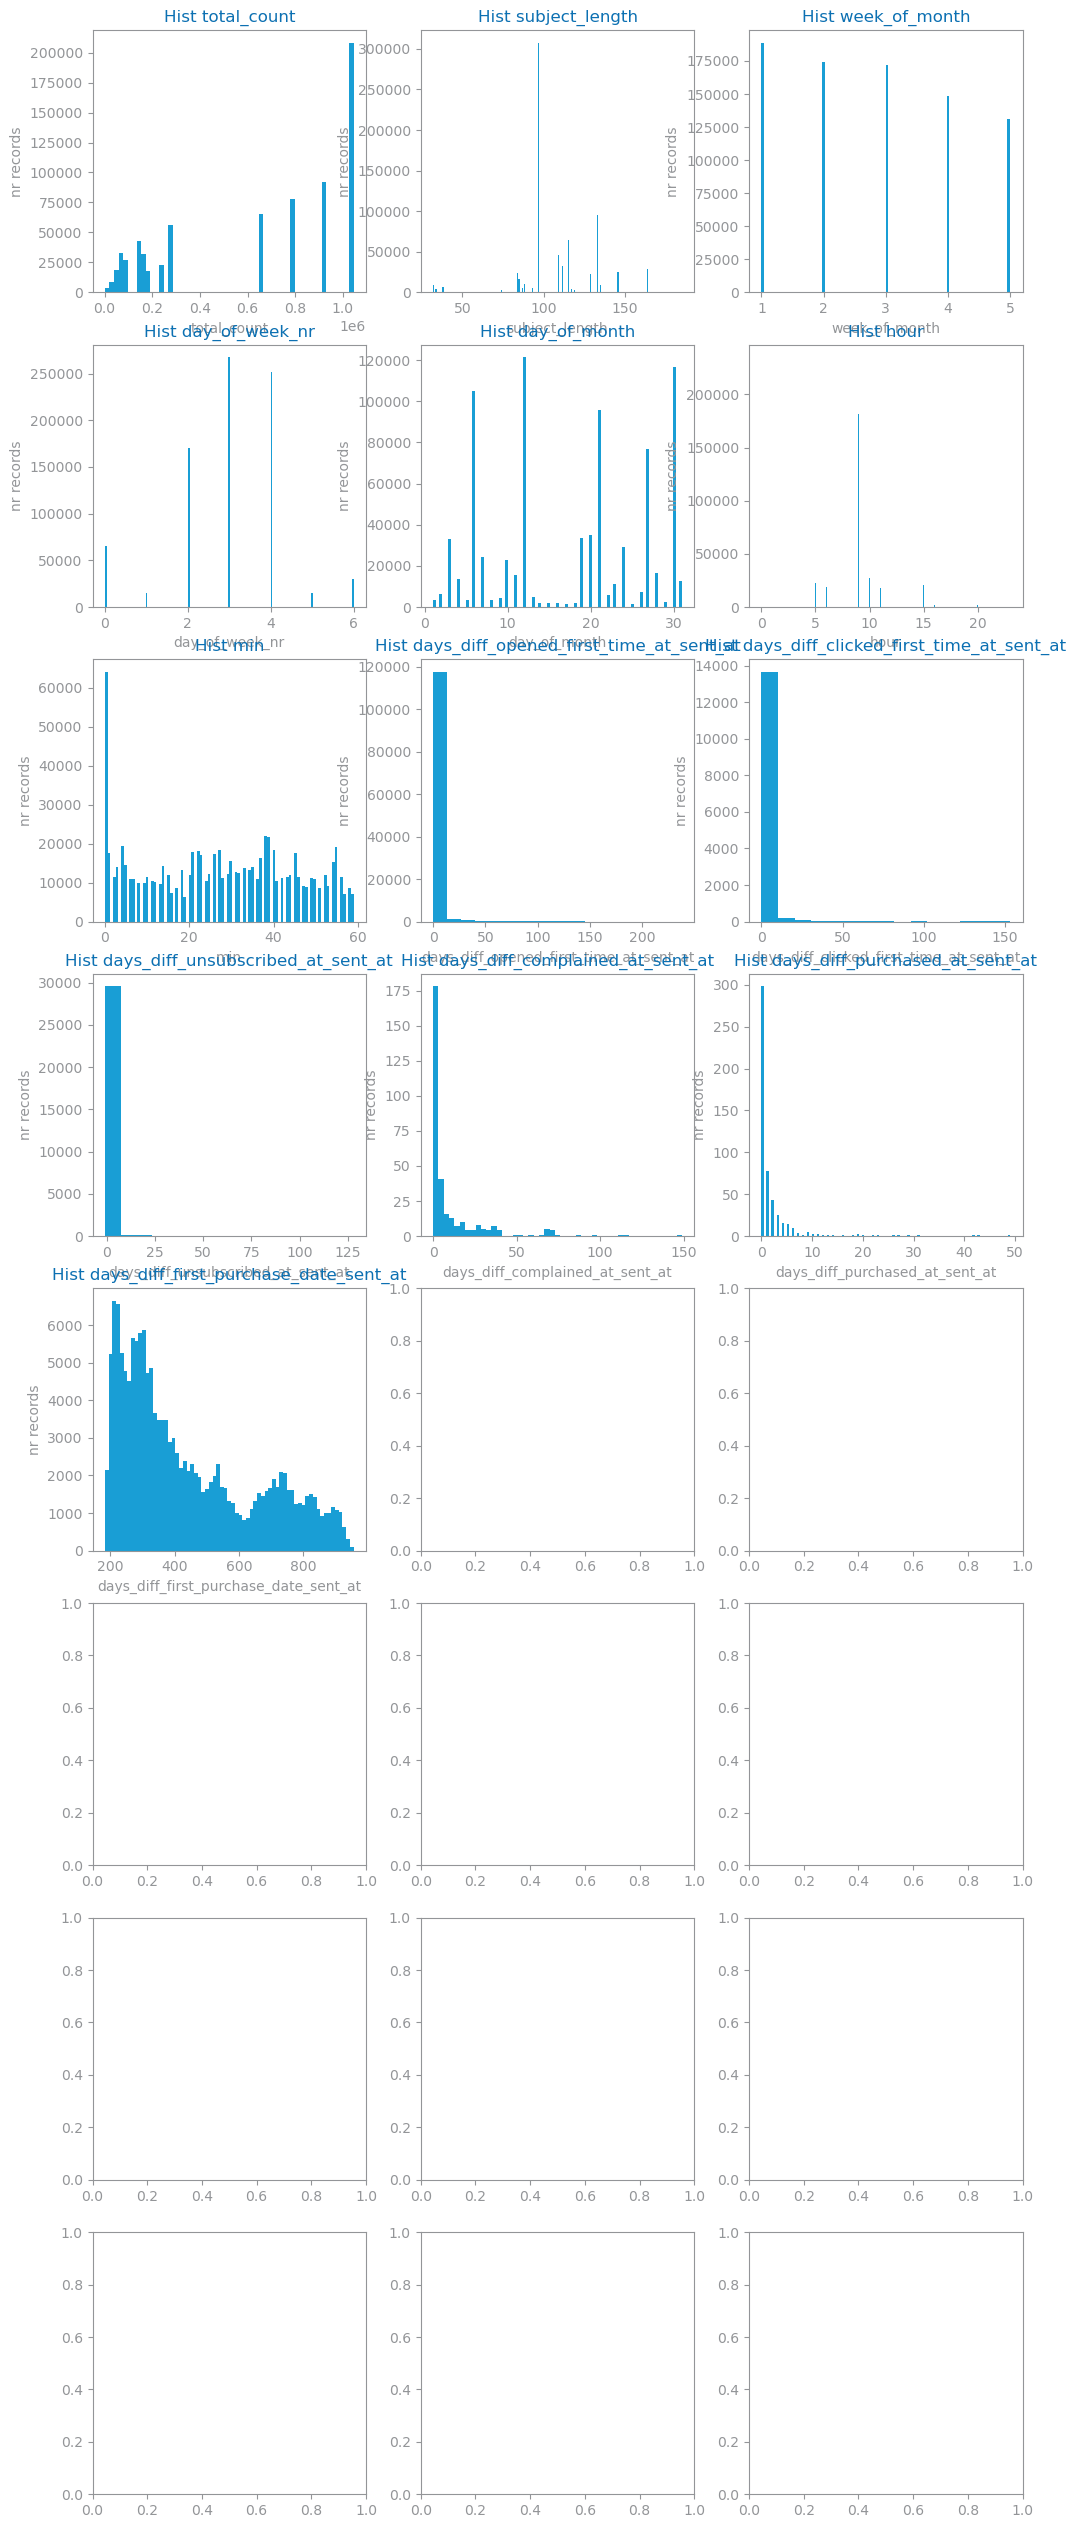

In [96]:
from dslabs_functions import set_chart_labels


if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i: int
    j: int
    i, j = 0, 0
    for n in range(len(numeric)):
        set_chart_labels(
            axs[i, j],
            title=f"Hist {numeric[n]}",
            xlabel=numeric[n],
            ylabel="nr records",
        )
        axs[i, j].hist(data[numeric[n]].dropna().values, "auto")
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    #savefig(f"./{file_tag}_single_histograms_numeric.png")
    show()
else:
    print("There are no numeric variables.")

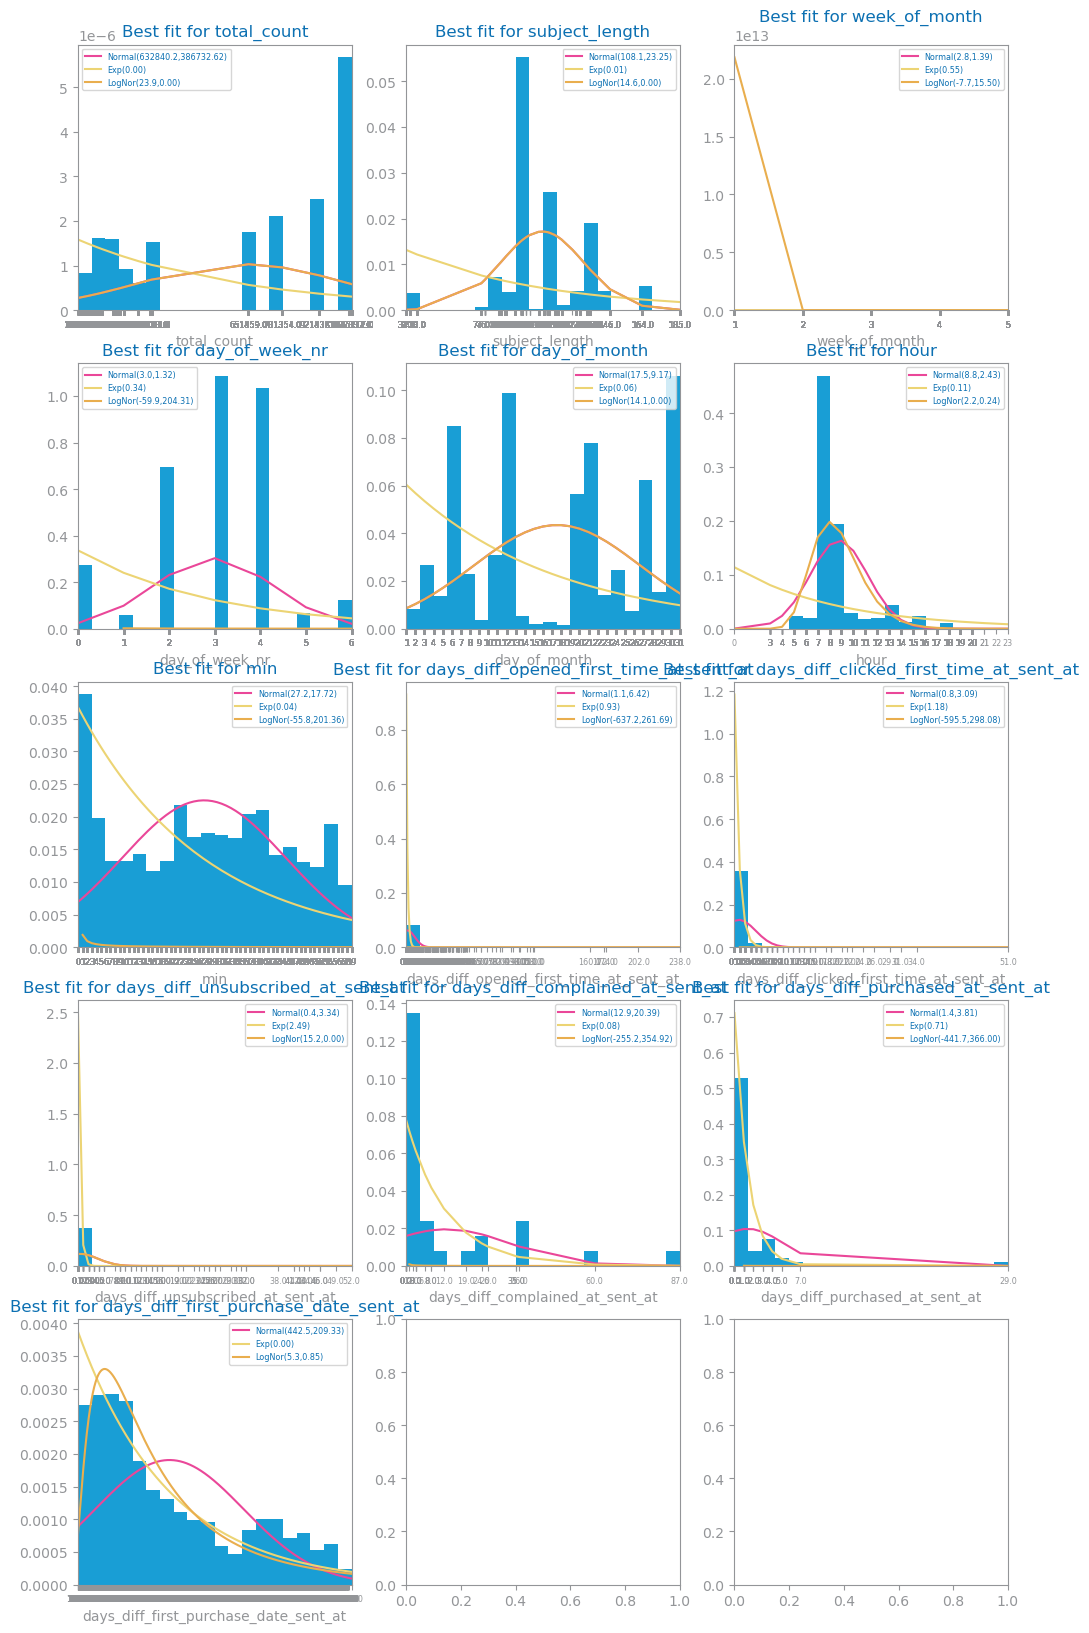

In [87]:
from numpy import log
from pandas import Series
from scipy.stats import norm, expon, lognorm
from matplotlib.axes import Axes
from dslabs_functions import plot_multiline_chart


def compute_known_distributions(x_values: list) -> dict:
    distributions = dict()
    if len(x_values) > 0:  # Check for empty list
        # Gaussian
        mean, sigma = norm.fit(x_values)
        distributions["Normal(%.1f,%.2f)" % (mean, sigma)] = norm.pdf(x_values, mean, sigma)
        # Exponential
        loc, scale = expon.fit(x_values)
        distributions["Exp(%.2f)" % (1 / scale)] = expon.pdf(x_values, loc, scale)
        # LogNorm
        sigma, loc, scale = lognorm.fit(x_values)
        distributions["LogNor(%.1f,%.2f)" % (log(scale), sigma)] = lognorm.pdf(
            x_values, sigma, loc, scale
        )
    return distributions


def histogram_with_distributions(ax: Axes, series: Series, var: str):
    values: list = series.sort_values().to_list()
    if len(values) > 0:  # Check for empty values list
        ax.hist(values, 20, density=True)
        distributions: dict = compute_known_distributions(values)
        plot_multiline_chart(
            values,
            distributions,
            ax=ax,
            title="Best fit for %s" % var,
            xlabel=var,
            ylabel="",
        )
    else:
        print(f"No data available for {var}")


if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(numeric)):
        histogram_with_distributions(axs[i, j], data[numeric[n]].dropna(), numeric[n])
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"./{file_tag}_histogram_numeric_distribution.png")
    show()
else:
    print("There are no numeric variables.")


## Symbolic Variables

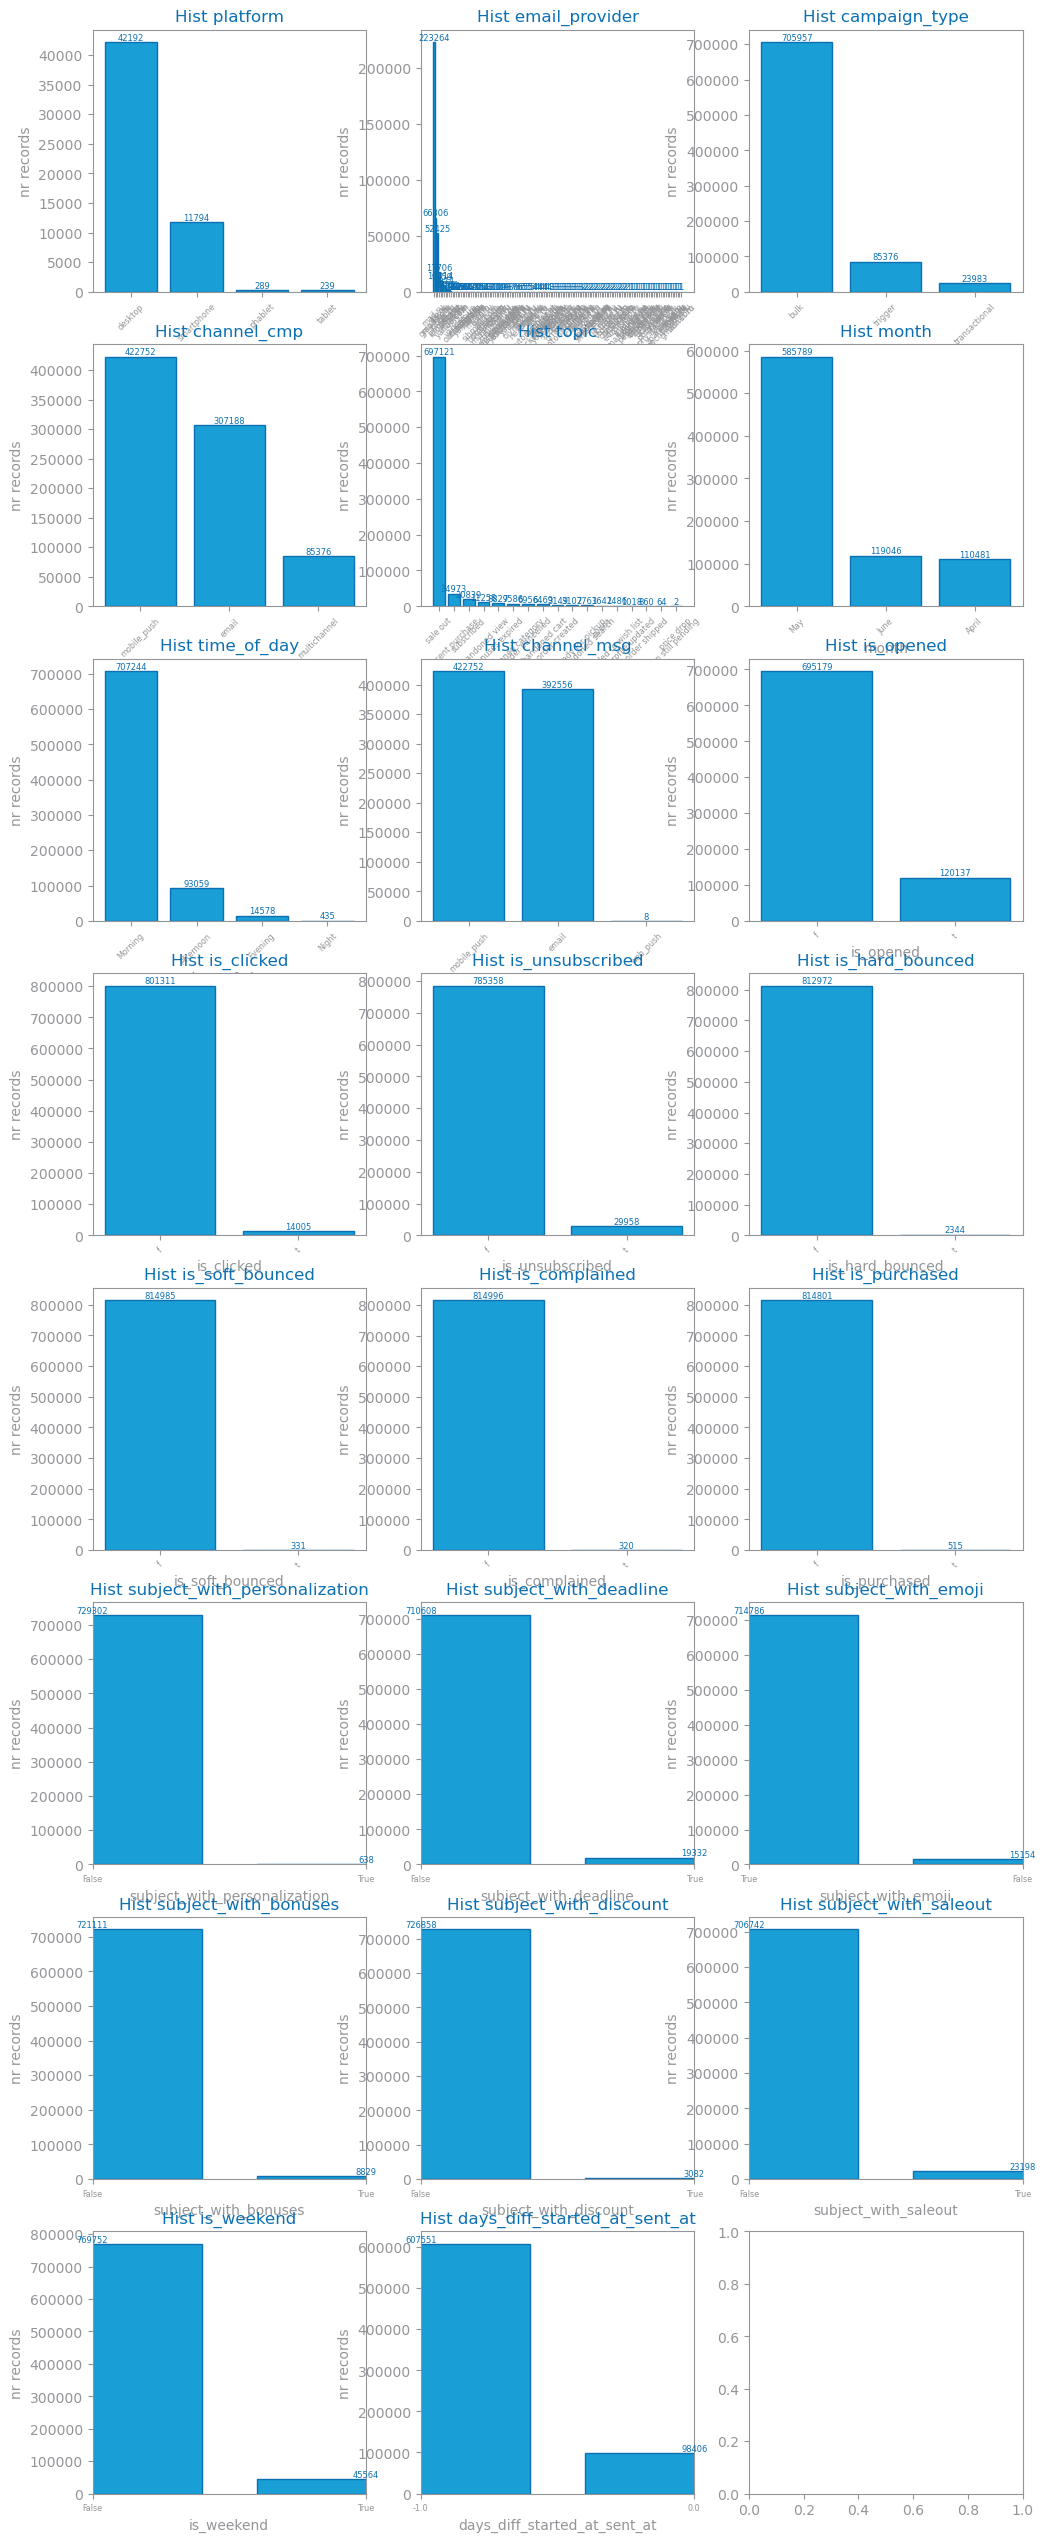

In [97]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT



symbolic: list[str] = variable_types["symbolic"] + variable_types["binary"]
if [] != symbolic:
    rows, cols = define_grid(len(symbolic))
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(symbolic)):
        counts: Series = data[symbolic[n]].value_counts()
        plot_bar_chart(
            counts.index.to_list(),
            counts.to_list(),
            ax=axs[i, j],
            title="Hist %s" % symbolic[n],
            xlabel=symbolic[n],
            ylabel="nr records",
            percentage=False,
        )
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"./{file_tag}_histograms_symbolic.png")
    show()
else:
    print("There are no symbolic variables.")

## Balancing and Class distribution


Counts:
is_unsubscribed
f    78535
t     2997
Name: count, dtype: int64

Percentages:
is_unsubscribed
f    96.324143
t     3.675857
Name: count, dtype: float64


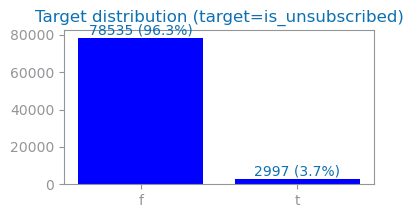

In [89]:
import matplotlib.pyplot as plt
import numpy as np

target = "is_unsubscribed"

values: Series = data[target].value_counts()
percentages: Series = (values / values.sum()) * 100  # Calculate the percentage for each category

print("Counts:")
print(values)
print("\nPercentages:")
print(percentages)

plt.figure(figsize=(4, 2))

bars = plt.bar(values.index.to_list(), values.to_list(), color='blue')

plt.title(f"Target distribution (target={target})")

for bar, p in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval} ({p:.1f}%)', ha='center', va='bottom')
plt.savefig(f"./{file_tag}_class_distribution.png")

plt.show()


# Granularity

## Dates

In [90]:
from pandas import DataFrame
#ver para weekend, dia da semana (mon, tue, thu), hora, minuto. estudar a granularidade destas variaveis.
#variáveis ciclicas.

def derive_date_variables(data: DataFrame, date_vars: list[str]) -> DataFrame:
    for date in date_vars:
        data[date + "_year"] = data[date].dt.year
        data[date + "_quarter"] = data[date].dt.quarter
        data[date + "_month"] = data[date].dt.month
        data[date + "_day"] = data[date].dt.day
    return data

In [91]:
from pandas import Series, to_numeric, to_datetime


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        else:
        # Check if the column is already of datetime type
            if pd.api.types.is_datetime64_any_dtype(df[c]):
                variable_types["date"].append(c)
            else:
                try:
                    to_numeric(df[c], errors="raise")
                    variable_types["numeric"].append(c)
                except ValueError:
                    try:
                        df[c] = to_datetime(df[c], errors="raise")
                        variable_types["date"].append(c)
                    except ValueError:
                        variable_types["symbolic"].append(c)

    return variable_types

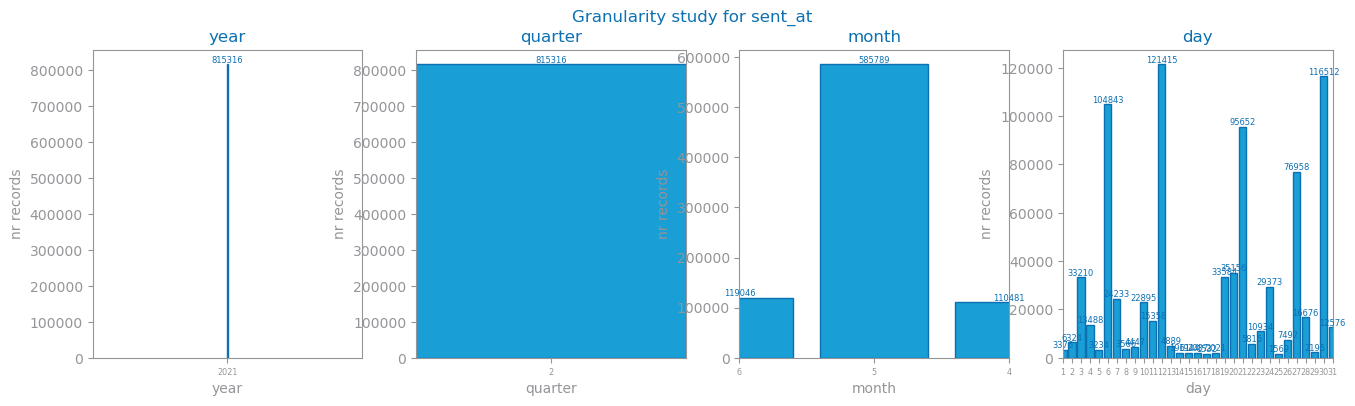

In [92]:
from numpy import ndarray
from pandas import Series, read_csv
from matplotlib.figure import Figure
from matplotlib.pyplot import subplots, savefig, show
from dslabs_functions import plot_bar_chart, HEIGHT
#get_variable_types

def analyse_date_granularity(data: DataFrame, var: str, levels: list[str]) -> ndarray:
    cols: int = len(levels)
    fig: Figure
    axs: ndarray
    fig, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    fig.suptitle(f"Granularity study for {var}")

    for i in range(cols):
        counts: Series[int] = data[var + "_" + levels[i]].value_counts()
        plot_bar_chart(
            counts.index.to_list(),
            counts.to_list(),
            ax=axs[0, i],
            title=levels[i],
            xlabel=levels[i],
            ylabel="nr records",
            percentage=False,
        )
    return axs


data: DataFrame = read_csv(
    filepath, index_col=None, parse_dates=True, dayfirst=True
)
variables_types: dict[str, list] = get_variable_types(data)
data_ext: DataFrame = derive_date_variables(data, variables_types["date"])

for v_date in variables_types["date"]:
    analyse_date_granularity(data, v_date, ["year", "quarter", "month", "day"])
    savefig(f"./{file_tag}_granularity_{v_date}.png")
    show()

# Sparsity
Note: scatter function is not able to deal with MV in non-numeric variables, and so we need to drop any of records having them (using the dropna method) heavy processing, use sampled data. -- use joao's sample_data in data_profiling


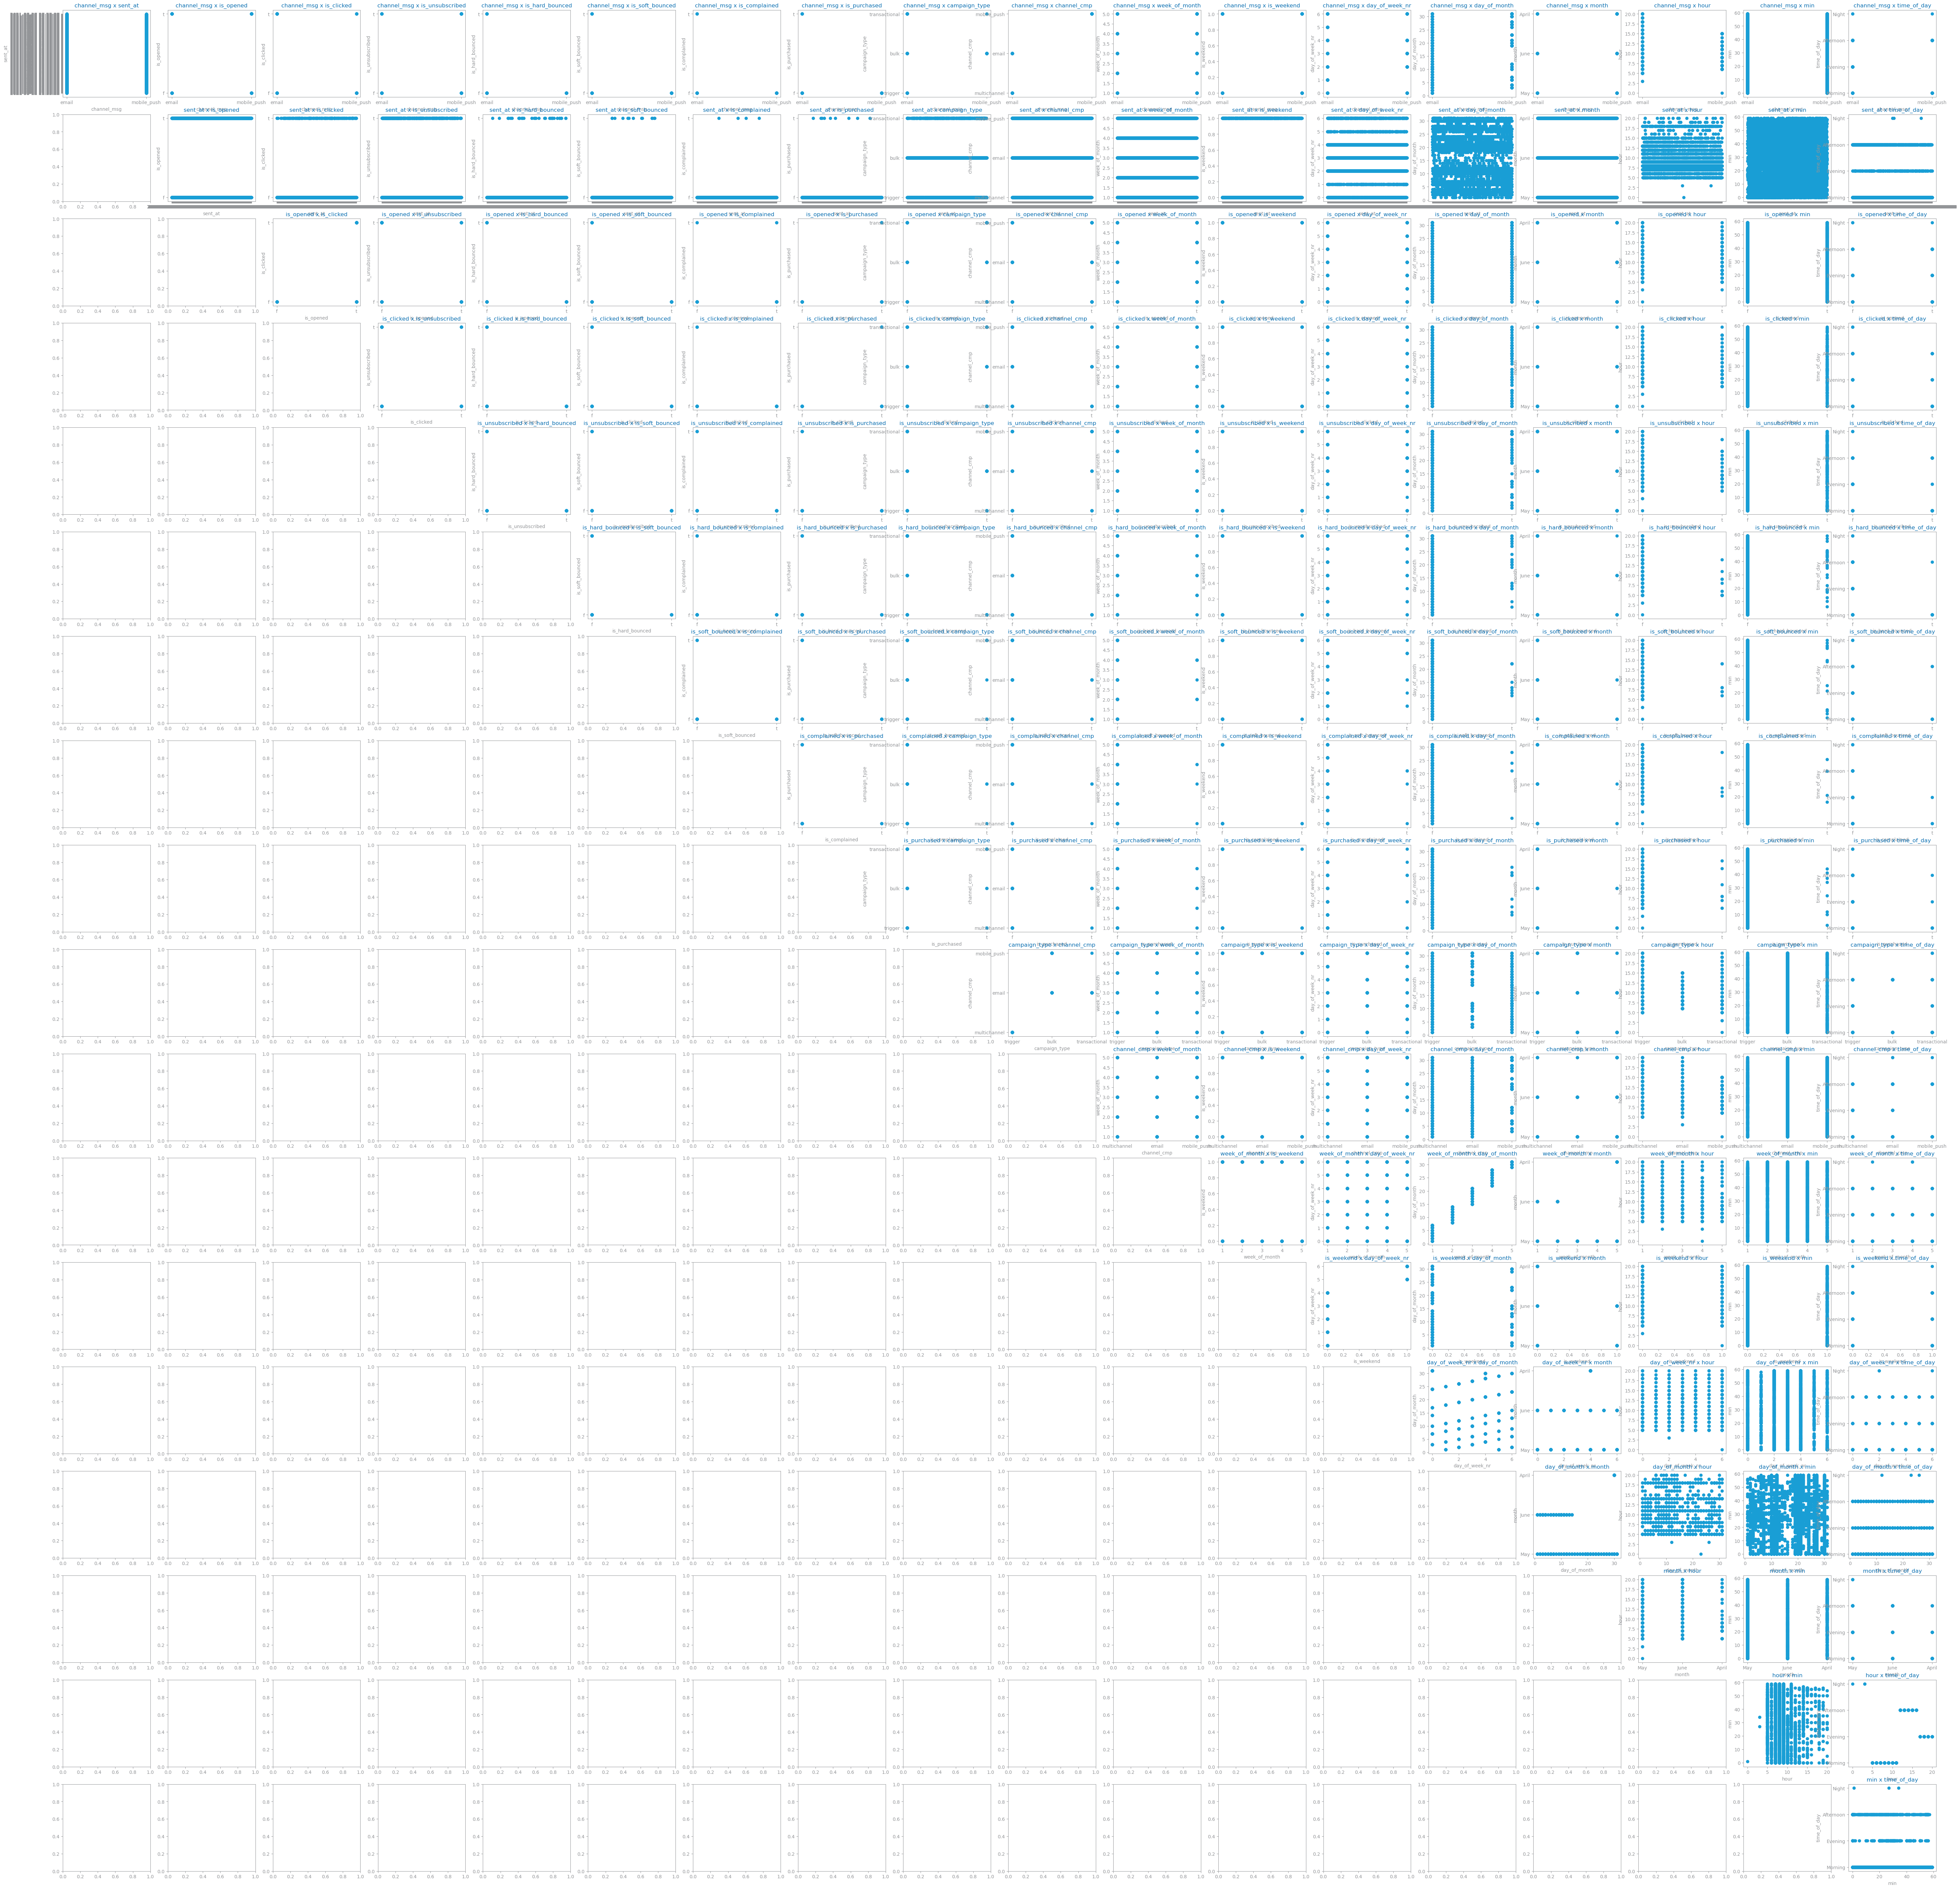

In [93]:
# Drop rows with NaN values
sampled_data = sampled_data.dropna(axis=1) #correr com axis=0 p retirar os records e nao as variaveis

# Check if sampled_data is empty after dropping NaNs
if sampled_data.empty:
    print("No data available after dropping NaN values.")
else:
    vars: list = sampled_data.columns.to_list()  # Ensure you're using sampled_data's columns

    if vars:  # Check if vars is not empty
        target = "is_unsubscribed"
        n: int = len(vars) - 1
        fig: Figure
        axs: ndarray
        fig, axs = subplots(n, n, figsize=(n * HEIGHT, n * HEIGHT), squeeze=False)

        for i in range(len(vars)):
            var1: str = vars[i]
            for j in range(i + 1, len(vars)):
                var2: str = vars[j]
                plot_multi_scatters_chart(sampled_data, var1, var2, ax=axs[i, j - 1])
        
        # Save the figure if needed
        savefig(f"./{file_tag}_sparsity_study.png")
        show()
    else:
        print("Sparsity class: there are no variables.")


Discriminate the records per class (target variable), in order to identify ranges of values specific for each class

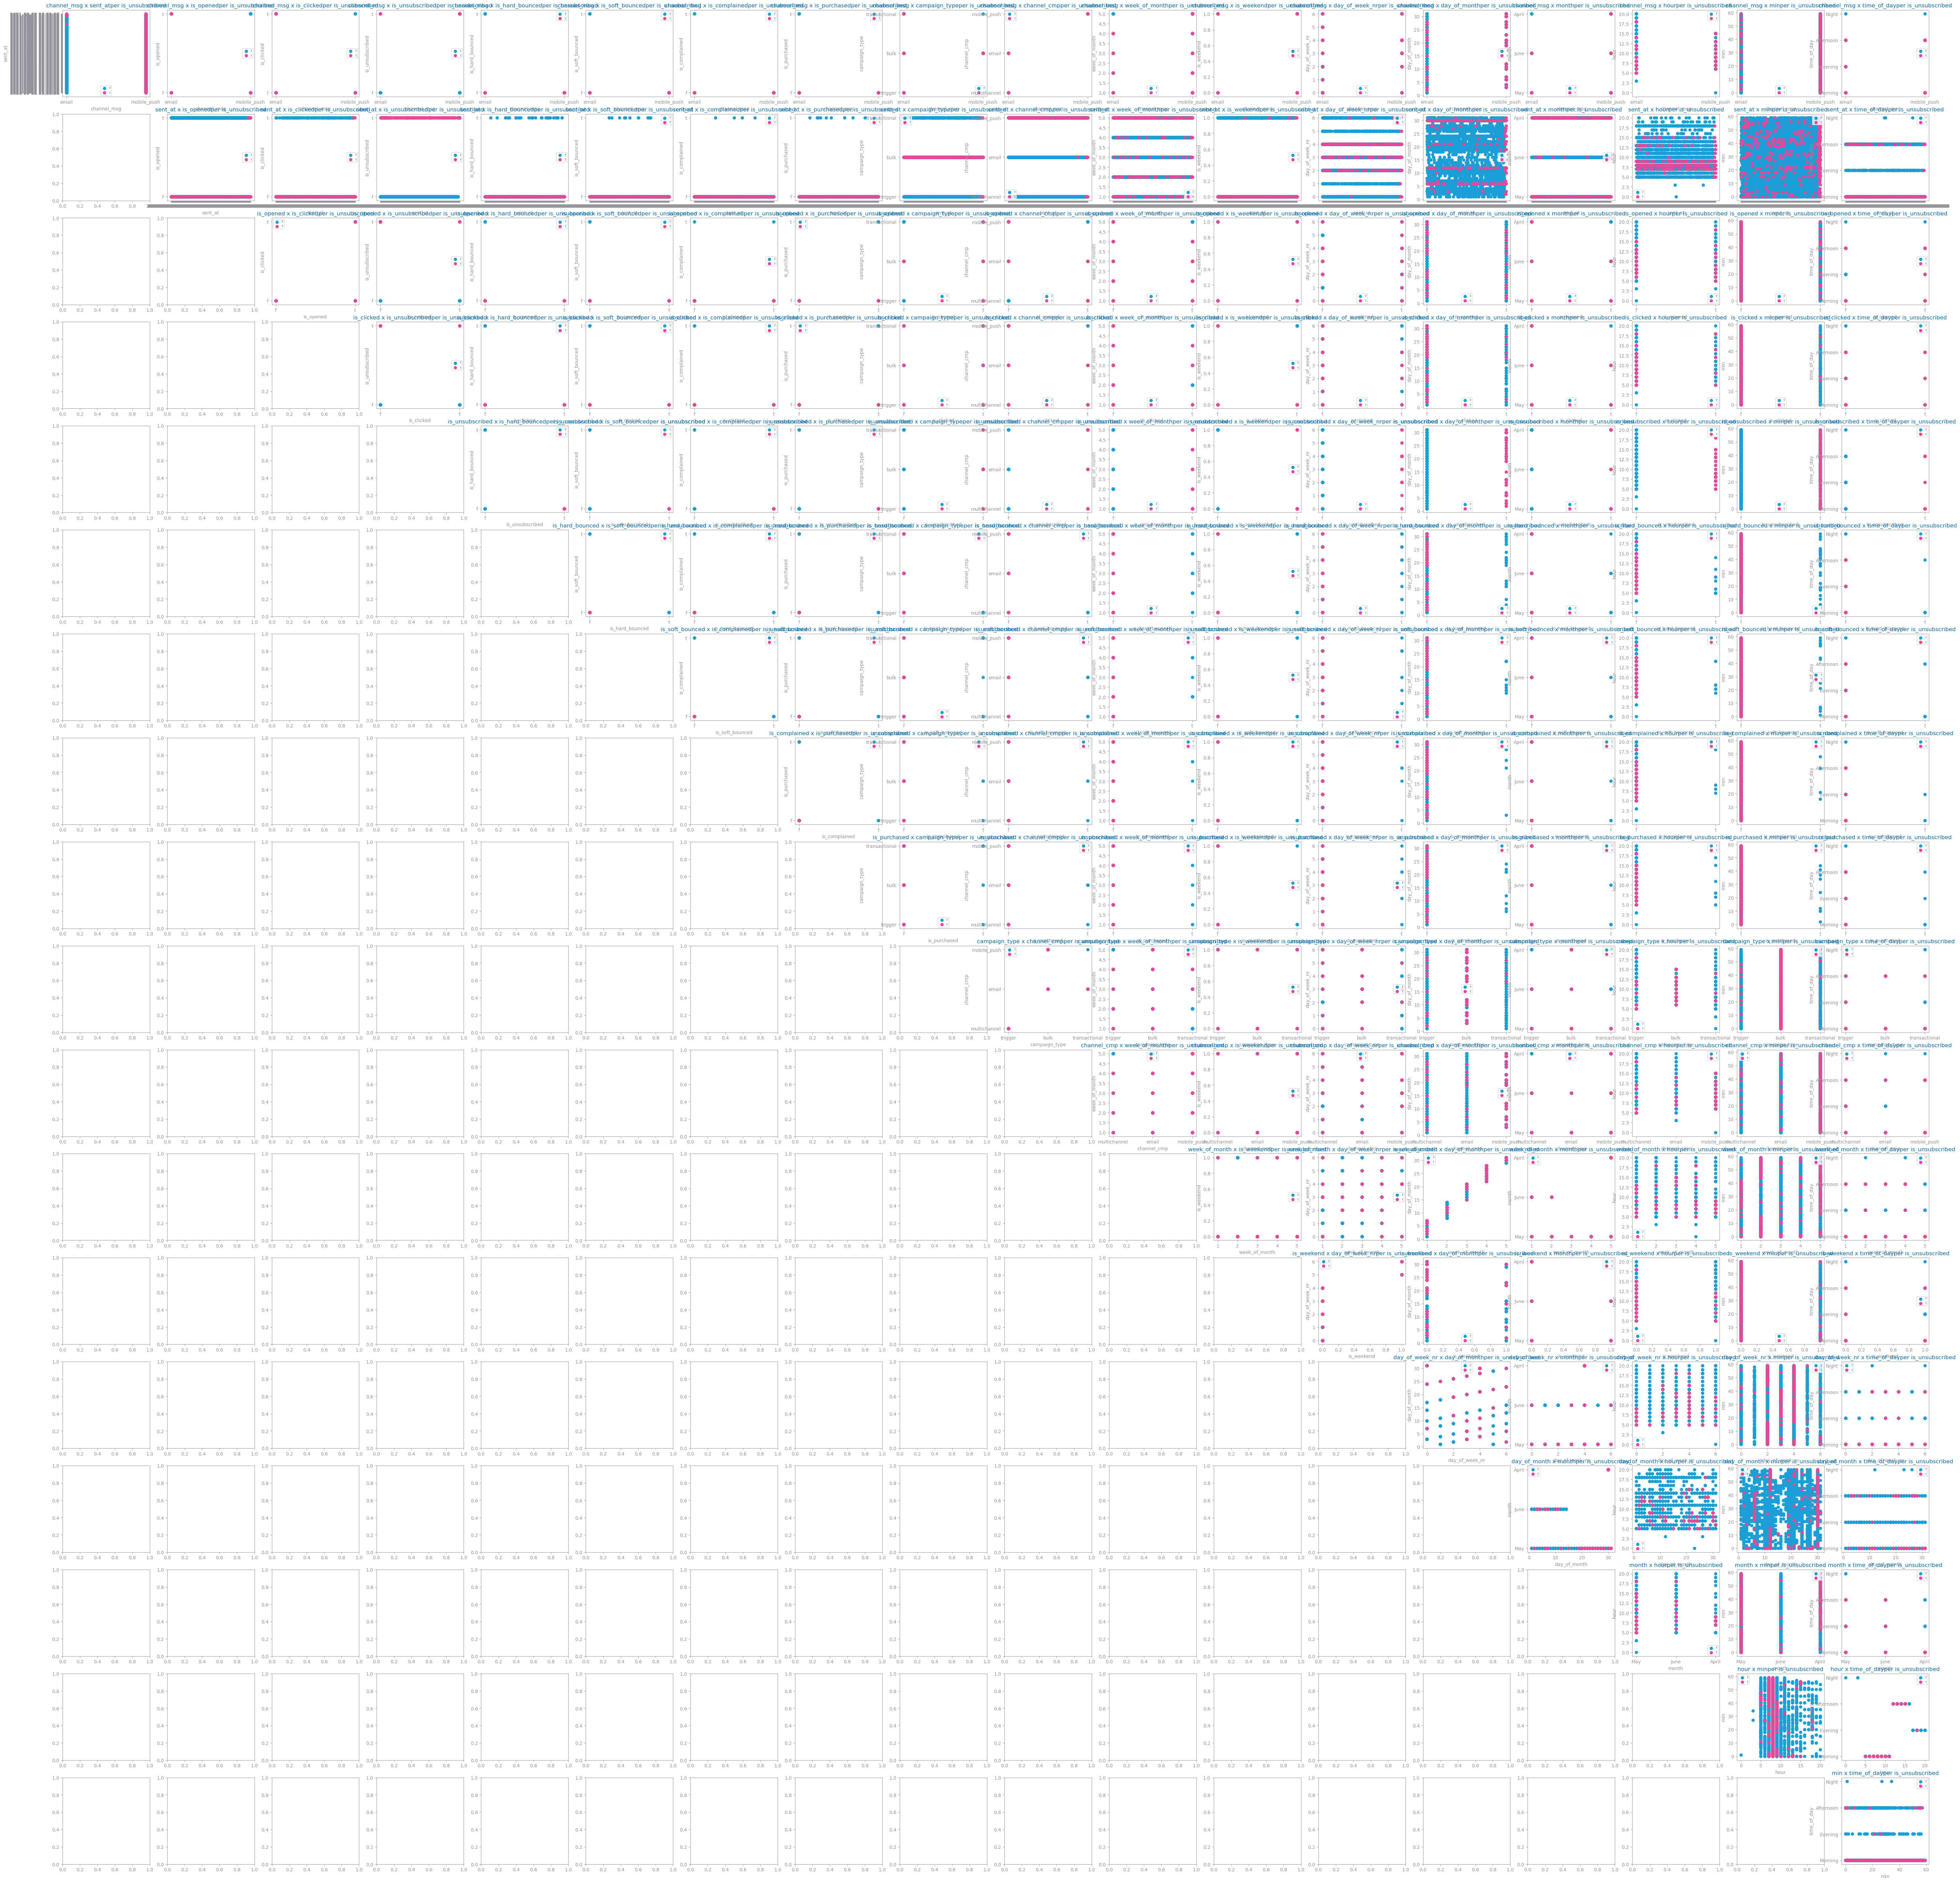

In [94]:
if [] != vars:
    target = "is_unsubscribed"

    n: int = len(vars) - 1
    fig, axs = subplots(n, n, figsize=(n * HEIGHT, n * HEIGHT), squeeze=False)
    for i in range(len(vars)):
        var1: str = vars[i]
        for j in range(i + 1, len(vars)):
            var2: str = vars[j]
            plot_multi_scatters_chart(sampled_data, var1, var2, target, ax=axs[i, j - 1])
    savefig(f"./{file_tag}_sparsity_per_class_study.png")
    show()
else:
    print("Sparsity per class: there are no variables.")

# Save df from preprocessing into a csv file

In [95]:
## Definir o caminho para salvar o arquivo CSV
#filepath = r'dataset/df_msg_data_prof.csv'
#
## Salvar o DataFrame em CSV
#data.to_csv(filepath, index=False)
#
#data.head()